In [2]:
import pandas as pd
import numpy as np
import glob
import os
from datetime import datetime
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, confusion_matrix
import itertools
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import recall_score

In [3]:
# function for plotting confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Preparing Data

In [4]:
# import data
url = 'https://github.com/qiuke12321/CS/blob/main/Application_Data.csv?raw=true'
df = pd.read_csv(url)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25128 entries, 0 to 25127
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Applicant_ID          25128 non-null  int64 
 1   Applicant_Gender      25128 non-null  object
 2   Owned_Car             25128 non-null  int64 
 3   Owned_Realty          25128 non-null  int64 
 4   Total_Children        25128 non-null  int64 
 5   Total_Income          25128 non-null  int64 
 6   Income_Type           25128 non-null  object
 7   Education_Type        25128 non-null  object
 8   Family_Status         25128 non-null  object
 9   Housing_Type          25128 non-null  object
 10  Owned_Mobile_Phone    25128 non-null  int64 
 11  Owned_Work_Phone      25128 non-null  int64 
 12  Owned_Phone           25128 non-null  int64 
 13  Owned_Email           25128 non-null  int64 
 14  Job_Title             25128 non-null  object
 15  Total_Family_Members  25128 non-null

In [5]:
# Extracting X and y from data, removing features not used
y=df.Status1
X=df.drop(columns=["Applicant_ID","Total_Bad_Debt","Total_Good_Debt","Status","Status2","Status1"])

In [6]:
# adding dummies for categorical features
X = pd.get_dummies(X, drop_first = False)
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25128 entries, 0 to 25127
Data columns (total 52 columns):
 #   Column                                                             Non-Null Count  Dtype
---  ------                                                             --------------  -----
 0   Owned_Car                                                          25128 non-null  int64
 1   Owned_Realty                                                       25128 non-null  int64
 2   Total_Children                                                     25128 non-null  int64
 3   Total_Income                                                       25128 non-null  int64
 4   Owned_Mobile_Phone                                                 25128 non-null  int64
 5   Owned_Work_Phone                                                   25128 non-null  int64
 6   Owned_Phone                                                        25128 non-null  int64
 7   Owned_Email                             

Text(0.5, 0, 'y')

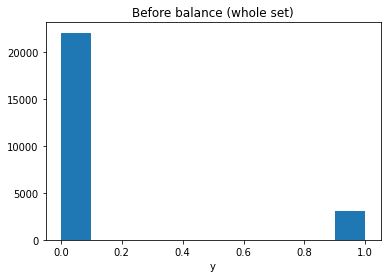

In [7]:
plt.hist(y)
plt.title("Before balance (whole set)")
plt.xlabel("y")

In [8]:
#Standarizing X
from sklearn.preprocessing import StandardScaler, MinMaxScaler
scaler = StandardScaler()
X=scaler.fit_transform(X)

In [9]:
# prepare train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=523, stratify=y)

In [10]:
# prepare validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=523)

In [11]:
# balance training set
from imblearn.over_sampling import SMOTE
oversample = SMOTE()
X_train, y_train = oversample.fit_resample(X_train, y_train)

Text(0.5, 0, 'y_train')

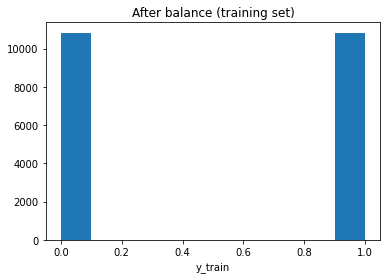

In [12]:
plt.hist(y_train)
plt.title("After balance (training set)")
plt.xlabel("y_train")

# Models and Experiments

## Base configuration

In [168]:
# Base configuration
tf.keras.backend.clear_session()
tf.random.set_seed(523)

model = keras.Sequential([
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid'),
],name="Base_model_1",)

#callback = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['AUC','accuracy'])

history = model.fit(X_train,
                    y_train,
                    epochs=200,
                    batch_size=512,
                    validation_data=(X_val, y_val), 
                    #callbacks=[callback],
                    verbose=1)

Epoch 1/200
43/43 [==============================] - 1s 10ms/step - loss: 0.7260 - auc: 0.5313 - accuracy: 0.5289 - val_loss: 0.6890 - val_auc: 0.5521 - val_accuracy: 0.5577
Epoch 2/200
43/43 [==============================] - 0s 4ms/step - loss: 0.6746 - auc: 0.6091 - accuracy: 0.5811 - val_loss: 0.6760 - val_auc: 0.5660 - val_accuracy: 0.5765
Epoch 3/200
43/43 [==============================] - 0s 4ms/step - loss: 0.6588 - auc: 0.6547 - accuracy: 0.6165 - val_loss: 0.6814 - val_auc: 0.5780 - val_accuracy: 0.5647
Epoch 4/200
43/43 [==============================] - 0s 5ms/step - loss: 0.6471 - auc: 0.6830 - accuracy: 0.6358 - val_loss: 0.6585 - val_auc: 0.5842 - val_accuracy: 0.6060
Epoch 5/200
43/43 [==============================] - 0s 4ms/step - loss: 0.6363 - auc: 0.7024 - accuracy: 0.6448 - val_loss: 0.6374 - val_auc: 0.5877 - val_accuracy: 0.6379
Epoch 6/200
43/43 [==============================] - 0s 4ms/step - loss: 0.6256 - auc: 0.7205 - accuracy: 0.6574 - val_loss: 0.6365 - 

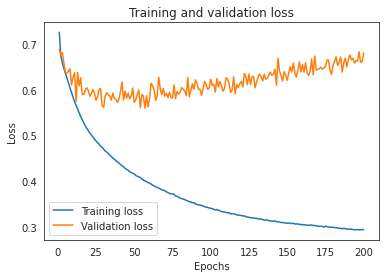

In [170]:
history_dict = history.history
history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
auc = history_dict['auc']
val_auc = history_dict['val_auc']


epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, label='Training loss')

plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

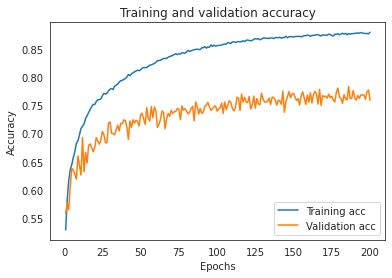

In [171]:
plt.clf()

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

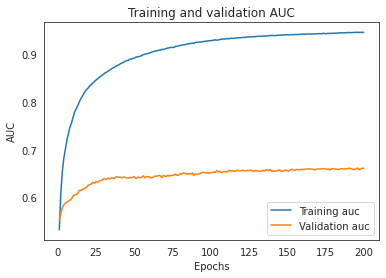

In [172]:
plt.clf()

plt.plot(epochs, auc, label='Training auc')
plt.plot(epochs, val_auc, label='Validation auc')
plt.title('Training and validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

plt.show()

## Deeper NN

In [175]:
# Deeper NN
tf.keras.backend.clear_session()
tf.random.set_seed(523)

model=keras.models.Sequential([
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(512, activation='relu'),  
    keras.layers.Dense(units=256,activation='relu'),  
    keras.layers.Dense(units=256,activation='relu'),    
    keras.layers.Dense(units=128,activation='relu'),
    keras.layers.Dense(units=1, activation="sigmoid"),
],name="Deeper_NN",)

#callback = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['AUC','accuracy'])

history = model.fit(X_train,
                    y_train,
                    epochs=200,
                    batch_size=512,
                    validation_data=(X_val, y_val), 
                    #callbacks=[callback],
                    verbose=1)

Epoch 1/200
43/43 [==============================] - 3s 49ms/step - loss: 0.6433 - auc: 0.6734 - accuracy: 0.6173 - val_loss: 0.6752 - val_auc: 0.6202 - val_accuracy: 0.6007
Epoch 2/200
43/43 [==============================] - 2s 42ms/step - loss: 0.5107 - auc: 0.8272 - accuracy: 0.7480 - val_loss: 0.5421 - val_auc: 0.6547 - val_accuracy: 0.7446
Epoch 3/200
43/43 [==============================] - 2s 42ms/step - loss: 0.4014 - auc: 0.8979 - accuracy: 0.8238 - val_loss: 0.5713 - val_auc: 0.6565 - val_accuracy: 0.7542
Epoch 4/200
43/43 [==============================] - 2s 42ms/step - loss: 0.3509 - auc: 0.9206 - accuracy: 0.8497 - val_loss: 0.5973 - val_auc: 0.6801 - val_accuracy: 0.7385
Epoch 5/200
43/43 [==============================] - 2s 42ms/step - loss: 0.3045 - auc: 0.9392 - accuracy: 0.8744 - val_loss: 0.5656 - val_auc: 0.6871 - val_accuracy: 0.7840
Epoch 6/200
43/43 [==============================] - 2s 42ms/step - loss: 0.2871 - auc: 0.9457 - accuracy: 0.8812 - val_loss: 0.60

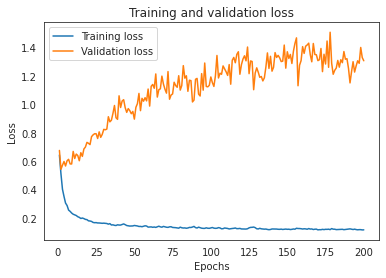

In [177]:
history_dict = history.history
history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
auc = history_dict['auc']
val_auc = history_dict['val_auc']


epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, label='Training loss')

plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

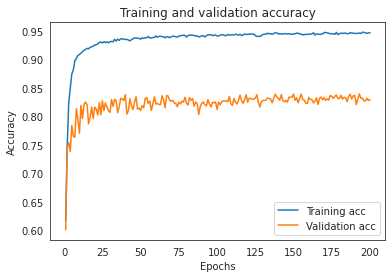

In [178]:
plt.clf()

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

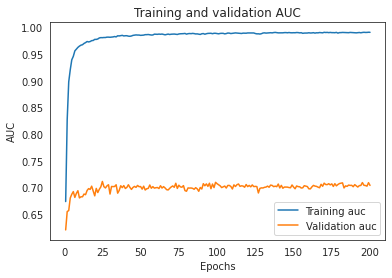

In [179]:
plt.clf()

plt.plot(epochs, auc, label='Training auc')
plt.plot(epochs, val_auc, label='Validation auc')
plt.title('Training and validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

plt.show()

## Regularization with Drop-out

In [79]:
# Regularization with Drop-out
tf.keras.backend.clear_session()
tf.random.set_seed(523)

model=keras.models.Sequential([
    
    keras.layers.Dense(512, activation='relu'),  
    keras.layers.Dropout(0.3),
    
    keras.layers.Dense(512, activation='relu'),  
    keras.layers.Dropout(0.3),

    keras.layers.Dense(units=256,activation='relu'), 
    keras.layers.Dropout(0.2),
    
    keras.layers.Dense(units=256,activation='relu'), 
    keras.layers.Dropout(0.2),
    
    keras.layers.Dense(units=128,activation='relu'),
    keras.layers.Dense(units=1, activation="sigmoid"),

],name="Dropout",)

#callback = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['AUC','accuracy'])

history = model.fit(X_train,
                    y_train,
                    epochs=200,
                    batch_size=512,
                    validation_data=(X_val, y_val), 
                    #callbacks=[callback],
                    verbose=1)

Epoch 1/200
43/43 [==============================] - 4s 58ms/step - loss: 0.6851 - auc: 0.5679 - accuracy: 0.5438 - val_loss: 0.7128 - val_auc: 0.5772 - val_accuracy: 0.4631
Epoch 2/200
43/43 [==============================] - 2s 52ms/step - loss: 0.6489 - auc: 0.6645 - accuracy: 0.6167 - val_loss: 0.6299 - val_auc: 0.6133 - val_accuracy: 0.6282
Epoch 3/200
43/43 [==============================] - 2s 52ms/step - loss: 0.6069 - auc: 0.7290 - accuracy: 0.6695 - val_loss: 0.6650 - val_auc: 0.6270 - val_accuracy: 0.5916
Epoch 4/200
43/43 [==============================] - 2s 51ms/step - loss: 0.5667 - auc: 0.7742 - accuracy: 0.7055 - val_loss: 0.6002 - val_auc: 0.6382 - val_accuracy: 0.6443
Epoch 5/200
43/43 [==============================] - 2s 52ms/step - loss: 0.5252 - auc: 0.8129 - accuracy: 0.7376 - val_loss: 0.5339 - val_auc: 0.6545 - val_accuracy: 0.7243
Epoch 6/200
43/43 [==============================] - 2s 51ms/step - loss: 0.5036 - auc: 0.8308 - accuracy: 0.7564 - val_loss: 0.60

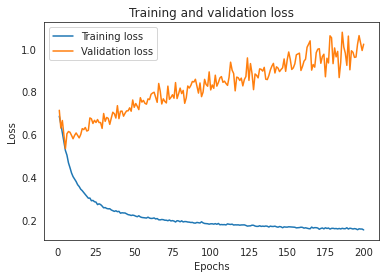

In [81]:
history_dict = history.history
history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
auc = history_dict['auc']
val_auc = history_dict['val_auc']


epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, label='Training loss')

plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

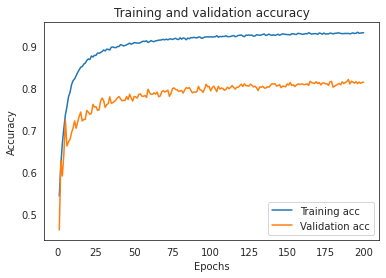

In [82]:
plt.clf()

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

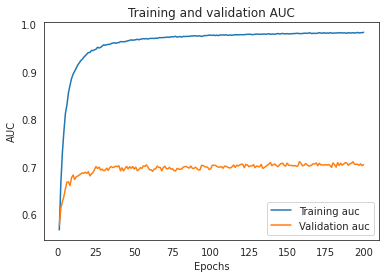

In [83]:
plt.clf()

plt.plot(epochs, auc, label='Training auc')
plt.plot(epochs, val_auc, label='Validation auc')
plt.title('Training and validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

plt.show()

## Batch normalization

In [86]:
# Batch normalization
tf.keras.backend.clear_session()
tf.random.set_seed(523)

model=keras.models.Sequential([
    
    keras.layers.Dense(512, activation='relu'), 
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    
    keras.layers.Dense(512, activation='relu'),  
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),

    keras.layers.Dense(units=256,activation='relu'), 
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    
    keras.layers.Dense(units=256,activation='relu'), 
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    
    keras.layers.Dense(units=128,activation='relu'),
    keras.layers.Dense(units=1, activation="sigmoid"),
    
],name="Batchnorm",)

#callback = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['AUC','accuracy'])

history = model.fit(X_train,
                    y_train,
                    epochs=200,
                    batch_size=512,
                    validation_data=(X_val, y_val), 
                    #callbacks=[callback],
                    verbose=1)

Epoch 1/200
43/43 [==============================] - 6s 83ms/step - loss: 0.7047 - auc: 0.5912 - accuracy: 0.5654 - val_loss: 0.7068 - val_auc: 0.5951 - val_accuracy: 0.4110
Epoch 2/200
43/43 [==============================] - 3s 74ms/step - loss: 0.6356 - auc: 0.6913 - accuracy: 0.6395 - val_loss: 0.7398 - val_auc: 0.6113 - val_accuracy: 0.3800
Epoch 3/200
43/43 [==============================] - 3s 71ms/step - loss: 0.5981 - auc: 0.7435 - accuracy: 0.6777 - val_loss: 0.7989 - val_auc: 0.6213 - val_accuracy: 0.3701
Epoch 4/200
43/43 [==============================] - 3s 70ms/step - loss: 0.5640 - auc: 0.7794 - accuracy: 0.7066 - val_loss: 0.9050 - val_auc: 0.6222 - val_accuracy: 0.3635
Epoch 5/200
43/43 [==============================] - 3s 70ms/step - loss: 0.5278 - auc: 0.8114 - accuracy: 0.7357 - val_loss: 0.8207 - val_auc: 0.6528 - val_accuracy: 0.4673
Epoch 6/200
43/43 [==============================] - 3s 72ms/step - loss: 0.4981 - auc: 0.8370 - accuracy: 0.7579 - val_loss: 0.82

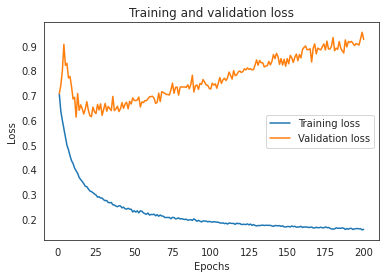

In [88]:
history_dict = history.history
history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
auc = history_dict['auc']
val_auc = history_dict['val_auc']


epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, label='Training loss')

plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

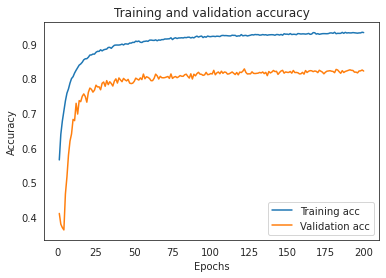

In [89]:
plt.clf()

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

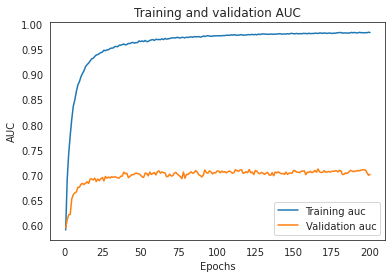

In [90]:
plt.clf()

plt.plot(epochs, auc, label='Training auc')
plt.plot(epochs, val_auc, label='Validation auc')
plt.title('Training and validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

plt.show()

## Leaky RELU

In [190]:
# Leaky RELU
tf.keras.backend.clear_session()
tf.random.set_seed(523)

model=keras.models.Sequential([
    
    keras.layers.Dense(512), 
    keras.layers.LeakyReLU(),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    
    keras.layers.Dense(512),  
    keras.layers.LeakyReLU(),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
keras.layers.Dense(units=256), 
    keras.layers.LeakyReLU(),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    
    keras.layers.Dense(units=256), 
    keras.layers.LeakyReLU(),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    
    keras.layers.Dense(units=128),
    keras.layers.LeakyReLU(), 
    keras.layers.Dense(units=1, activation="sigmoid"),
],name="LeakyRELU",)

#callback = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['AUC','accuracy'])

history = model.fit(X_train,
                    y_train,
                    epochs=200,
                    batch_size=512,
                    validation_data=(X_val, y_val), 
                    #callbacks=[callback],
                    verbose=1)

Epoch 1/200
43/43 [==============================] - 9s 125ms/step - loss: 0.7151 - auc: 0.5718 - accuracy: 0.5534 - val_loss: 0.6893 - val_auc: 0.5653 - val_accuracy: 0.5507
Epoch 2/200
43/43 [==============================] - 3s 66ms/step - loss: 0.6416 - auc: 0.6787 - accuracy: 0.6282 - val_loss: 0.7409 - val_auc: 0.6041 - val_accuracy: 0.4338
Epoch 3/200
43/43 [==============================] - 3s 65ms/step - loss: 0.6181 - auc: 0.7147 - accuracy: 0.6525 - val_loss: 0.7763 - val_auc: 0.6116 - val_accuracy: 0.4266
Epoch 4/200
43/43 [==============================] - 3s 66ms/step - loss: 0.5903 - auc: 0.7490 - accuracy: 0.6822 - val_loss: 0.8472 - val_auc: 0.6183 - val_accuracy: 0.3917
Epoch 5/200
43/43 [==============================] - 3s 66ms/step - loss: 0.5653 - auc: 0.7764 - accuracy: 0.7066 - val_loss: 0.8830 - val_auc: 0.6166 - val_accuracy: 0.4108
Epoch 6/200
43/43 [==============================] - 3s 66ms/step - loss: 0.5425 - auc: 0.7992 - accuracy: 0.7259 - val_loss: 0.7

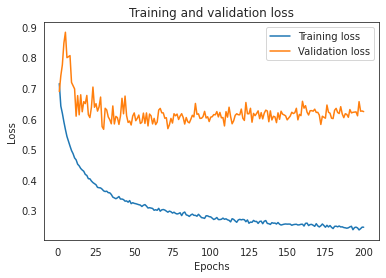

In [192]:
history_dict = history.history
history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
auc = history_dict['auc']
val_auc = history_dict['val_auc']


epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, label='Training loss')

plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

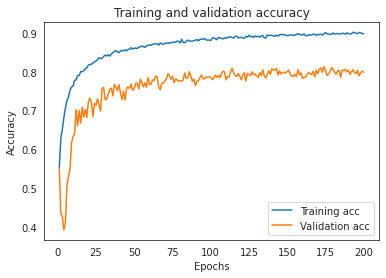

In [193]:
plt.clf()

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

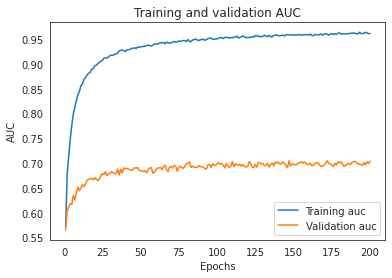

In [194]:
plt.clf()

plt.plot(epochs, auc, label='Training auc')
plt.plot(epochs, val_auc, label='Validation auc')
plt.title('Training and validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

plt.show()

## Larger network

In [100]:
# Larger network
tf.keras.backend.clear_session()
tf.random.set_seed(523)

model=keras.models.Sequential([
    
    keras.layers.Dense(1024), 
    keras.layers.LeakyReLU(),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.4),
    
    keras.layers.Dense(512),  
    keras.layers.LeakyReLU(),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(512),  
    keras.layers.LeakyReLU(),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    
    keras.layers.Dense(units=256), 
    keras.layers.LeakyReLU(),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    
    keras.layers.Dense(units=256), 
    keras.layers.LeakyReLU(),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.1),
    keras.layers.Dense(units=128),
    keras.layers.LeakyReLU(), 
    #keras.layers.Dropout(0.05),
    keras.layers.Dense(units=1, activation="sigmoid"),
],name="Larger_network",)


#callback = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['AUC','accuracy'])

history = model.fit(X_train,
                    y_train,
                    epochs=200,
                    batch_size=512,
                    validation_data=(X_val, y_val), 
                    #callbacks=[callback],
                    verbose=1)

Epoch 1/200
43/43 [==============================] - 8s 129ms/step - loss: 0.7081 - auc: 0.5701 - accuracy: 0.5487 - val_loss: 0.7420 - val_auc: 0.5855 - val_accuracy: 0.3083
Epoch 2/200
43/43 [==============================] - 5s 119ms/step - loss: 0.6516 - auc: 0.6640 - accuracy: 0.6171 - val_loss: 0.8192 - val_auc: 0.5934 - val_accuracy: 0.2873
Epoch 3/200
43/43 [==============================] - 5s 120ms/step - loss: 0.6212 - auc: 0.7112 - accuracy: 0.6527 - val_loss: 0.9992 - val_auc: 0.6050 - val_accuracy: 0.2346
Epoch 4/200
43/43 [==============================] - 5s 120ms/step - loss: 0.5820 - auc: 0.7594 - accuracy: 0.6911 - val_loss: 1.0350 - val_auc: 0.5978 - val_accuracy: 0.3004
Epoch 5/200
43/43 [==============================] - 5s 118ms/step - loss: 0.5617 - auc: 0.7811 - accuracy: 0.7142 - val_loss: 1.0042 - val_auc: 0.6240 - val_accuracy: 0.3642
Epoch 6/200
43/43 [==============================] - 5s 118ms/step - loss: 0.5350 - auc: 0.8061 - accuracy: 0.7309 - val_loss

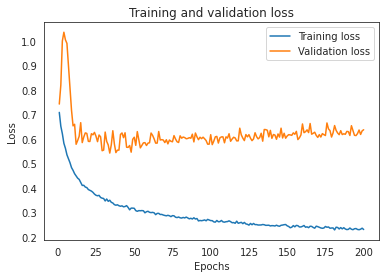

In [102]:
history_dict = history.history
history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
auc = history_dict['auc']
val_auc = history_dict['val_auc']


epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, label='Training loss')

plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

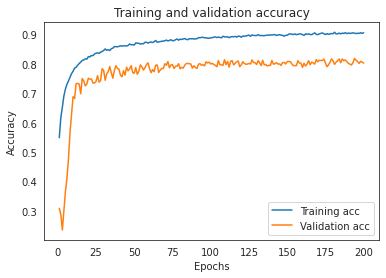

In [103]:
plt.clf()

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

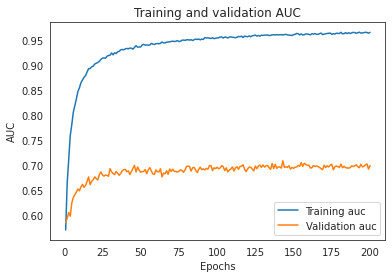

In [104]:
plt.clf()

plt.plot(epochs, auc, label='Training auc')
plt.plot(epochs, val_auc, label='Validation auc')
plt.title('Training and validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

plt.show()

## Adjusting learning rate decay

In [23]:
# Adjusting learning rate decay end = 0.0001 (not used)
tf.keras.backend.clear_session()
tf.random.set_seed(523)

model=keras.models.Sequential([
    
    
    keras.layers.Dense(512),  
    keras.layers.LeakyReLU(),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(512),  
    keras.layers.LeakyReLU(),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    
    keras.layers.Dense(units=256), 
    keras.layers.LeakyReLU(),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    
    keras.layers.Dense(units=256), 
    keras.layers.LeakyReLU(),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=128),
    keras.layers.LeakyReLU(), 
    keras.layers.Dense(units=1, activation="sigmoid"),
],name="Learning_rate_decay",)


#callback = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True)


#Add learning rate decay to Adam optimizer
optimizer = keras.optimizers.Adam(learning_rate=0.005, decay=5e-2)


model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['AUC','accuracy'])

history = model.fit(X_train,
                    y_train,
                    epochs=200,
                    batch_size=512,
                    validation_data=(X_val, y_val), 
                    #callbacks=[callback],
                    verbose=1)

Epoch 1/200
49/49 [==============================] - 6s 74ms/step - loss: 0.7352 - auc: 0.5793 - accuracy: 0.5605 - val_loss: 0.6508 - val_auc: 0.5743 - val_accuracy: 0.6148
Epoch 2/200
49/49 [==============================] - 3s 71ms/step - loss: 0.6393 - auc: 0.6825 - accuracy: 0.6287 - val_loss: 0.6786 - val_auc: 0.6255 - val_accuracy: 0.5520
Epoch 3/200
49/49 [==============================] - 3s 67ms/step - loss: 0.6124 - auc: 0.7225 - accuracy: 0.6615 - val_loss: 0.7564 - val_auc: 0.6209 - val_accuracy: 0.4556
Epoch 4/200
49/49 [==============================] - 3s 66ms/step - loss: 0.5953 - auc: 0.7444 - accuracy: 0.6813 - val_loss: 0.7488 - val_auc: 0.6343 - val_accuracy: 0.4697
Epoch 5/200
49/49 [==============================] - 3s 67ms/step - loss: 0.5791 - auc: 0.7628 - accuracy: 0.6941 - val_loss: 0.7769 - val_auc: 0.6473 - val_accuracy: 0.4648
Epoch 6/200
49/49 [==============================] - 3s 67ms/step - loss: 0.5665 - auc: 0.7776 - accuracy: 0.7067 - val_loss: 0.74

In [13]:
# Adjusting learning rate decay end = 0.001
tf.keras.backend.clear_session()
tf.random.set_seed(523)

model=keras.models.Sequential([
    
    
    keras.layers.Dense(512),  
    keras.layers.LeakyReLU(),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(512),  
    keras.layers.LeakyReLU(),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.3),
    
    keras.layers.Dense(units=256), 
    keras.layers.LeakyReLU(),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    
    keras.layers.Dense(units=256), 
    keras.layers.LeakyReLU(),
    keras.layers.BatchNormalization(),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(units=128),
    keras.layers.LeakyReLU(), 
    keras.layers.Dense(units=1, activation="sigmoid"),
],name="Learning_rate_decay",)


#callback = tf.keras.callbacks.EarlyStopping(monitor='val_auc', patience=5, restore_best_weights=True)


#Add learning rate decay to Adam optimizer
optimizer = keras.optimizers.Adam(learning_rate=0.005, decay=5e-3)


model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['AUC','accuracy'])

history = model.fit(X_train,
                    y_train,
                    epochs=200,
                    batch_size=512,
                    validation_data=(X_val, y_val), 
                    #callbacks=[callback],
                    verbose=1)

Epoch 1/200
43/43 [==============================] - 6s 87ms/step - loss: 0.7278 - auc: 0.5824 - accuracy: 0.5613 - val_loss: 0.6568 - val_auc: 0.5689 - val_accuracy: 0.6225
Epoch 2/200
43/43 [==============================] - 3s 64ms/step - loss: 0.6385 - auc: 0.6855 - accuracy: 0.6316 - val_loss: 0.6222 - val_auc: 0.5977 - val_accuracy: 0.6553
Epoch 3/200
43/43 [==============================] - 3s 63ms/step - loss: 0.5975 - auc: 0.7410 - accuracy: 0.6795 - val_loss: 0.6665 - val_auc: 0.6190 - val_accuracy: 0.6058
Epoch 4/200
43/43 [==============================] - 3s 64ms/step - loss: 0.5644 - auc: 0.7769 - accuracy: 0.7056 - val_loss: 0.6645 - val_auc: 0.6211 - val_accuracy: 0.6051
Epoch 5/200
43/43 [==============================] - 4s 92ms/step - loss: 0.5428 - auc: 0.7985 - accuracy: 0.7256 - val_loss: 0.7480 - val_auc: 0.6042 - val_accuracy: 0.5551
Epoch 6/200
43/43 [==============================] - 6s 130ms/step - loss: 0.5152 - auc: 0.8220 - accuracy: 0.7438 - val_loss: 0.8

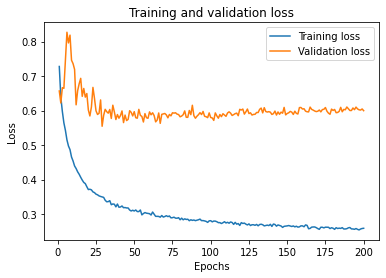

In [14]:
history_dict = history.history
history_dict.keys()

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']
auc = history_dict['auc']
val_auc = history_dict['val_auc']


epochs = range(1, len(acc) + 1)


plt.plot(epochs, loss, label='Training loss')

plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

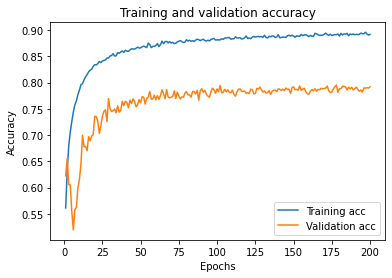

In [15]:
plt.clf()

plt.plot(epochs, acc, label='Training acc')
plt.plot(epochs, val_acc, label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

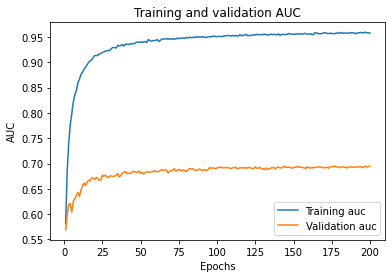

In [16]:
plt.clf()

plt.plot(epochs, auc, label='Training auc')
plt.plot(epochs, val_auc, label='Validation auc')
plt.title('Training and validation AUC')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

plt.show()

In [17]:
final_model = model

#Testing

In [18]:
final_model.summary()

Model: "Learning_rate_decay"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               27136     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 512)               0         
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 512)               0         
                                               

In [19]:
print(final_model.evaluate(X_test, y_test))

236/236 [==============================] - 1s 3ms/step - loss: 0.6028 - auc: 0.6998 - accuracy: 0.7882
[0.6027646064758301, 0.6997935175895691, 0.78816819190979]


      0     1
0  5478  1135
1   462   464
[[0.82836837 0.17163163]
 [0.49892009 0.50107991]]


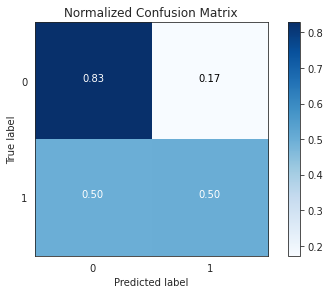

In [20]:
y_predict = final_model.predict(X_test)
yHat = (y_predict >= 0.5).astype(int)
print(pd.DataFrame(confusion_matrix(y_test,yHat)))

sns.set_style('white') 
class_names = ['0','1']
plot_confusion_matrix(confusion_matrix(y_test, yHat),
                      classes= class_names, normalize = True, 
                      title='Normalized Confusion Matrix')

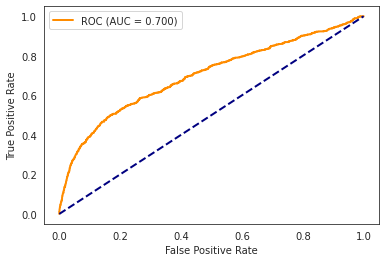

AUC = 0.700


In [21]:
auc = roc_auc_score(y_test, y_predict)

fpr, tpr, _ = roc_curve(y_test, y_predict)
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC (AUC = %0.3f)' % auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

print('AUC = %.3f' % (auc))